In [28]:
%pylab inline

import networkx as nx
import scipy.sparse
from sklearn.datasets import make_sparse_spd_matrix

import regain; reload(regain)
from regain.datasets import is_pos_def, is_pos_semidef
from regain.datasets import generate_ma_xue_zou
from regain.plot import plot_graph_with_latent_variables
import math

Populating the interactive namespace from numpy and matplotlib


In [38]:
def generate_dataset_L1(n_dim_obs=10, n_dim_lat=2, T=10, degree=2, proportional=False):

    K_HO = np.zeros((n_dim_lat, n_dim_obs))
    for i in range(n_dim_lat):
        percentage = int(n_dim_obs * 0.8)
        indices = np.random.randint(0, high=n_dim_obs, size=percentage)
        K_HO[i, indices] = np.random.rand(percentage) * 0.12
    L = K_HO.T.dot(K_HO)
    assert(is_pos_semidef(L))
    assert np.linalg.matrix_rank(L) == n_dim_lat

    theta = np.eye(n_dim_obs)
    for i in range(n_dim_obs):
        l = list(set(np.arange(0, n_dim_obs)) -
                set().union(list(np.nonzero(theta[i,:])[0]),
                            list(np.where(np.count_nonzero(theta, axis=1)>=3)[0])))
        if len(l)==0: continue
        indices = np.random.choice(l, degree-(np.count_nonzero(theta[i,:])-1))
        theta[i, indices] = theta[indices, i] = .5 / degree
    assert(is_pos_def(theta))
    theta_observed = theta - L
    assert(is_pos_def(theta_observed))

    thetas = [theta]
    thetas_obs = [theta_observed]
    ells = [L]
    K_HOs = [K_HO]

    for i in range(1,T):
        if proportional:
            no = int(math.ceil(n_dim_obs/20))
        else:
            no=1
        
        rows = np.zeros(no)
        cols = np.zeros(no)
        while (np.any(rows==cols)):
            rows = np.random.randint(0, n_dim_obs, no)
            cols = np.random.randint(0, n_dim_obs, no)
        theta = thetas[-1].copy()
        for r, c in zip(rows, cols):
            theta[r,c] = 0.12 if theta[r,c] == 0 else 0;
            theta[c,r] = theta[r,c]
       # print(theta)
        assert(is_pos_def(theta))

        K_HO = K_HOs[-1].copy()
        c = np.random.randint(0, n_dim_obs, 1)
        r = np.random.randint(0, n_dim_lat, 1)
        K_HO[r,c] = 0.12 if K_HO[r,c] == 0 else 0;
        #K_HO[c,r] = K_HO[r,c]
        
        L = K_HO.T.dot(K_HO)
        assert np.linalg.matrix_rank(L) == n_dim_lat
        assert(is_pos_semidef(L))
        assert(is_pos_def(theta - L))
        
        thetas.append(theta)
        thetas_obs.append(theta - L)
        ells.append(L)
        K_HOs.append(K_HO)

    return thetas, thetas_obs, ells

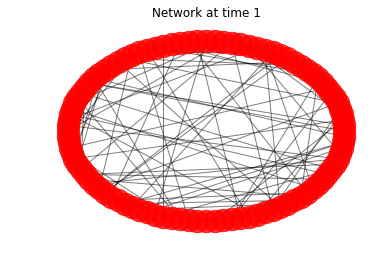

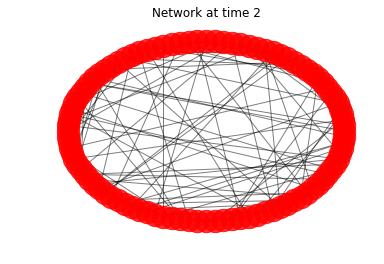

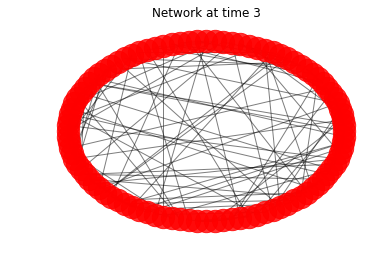

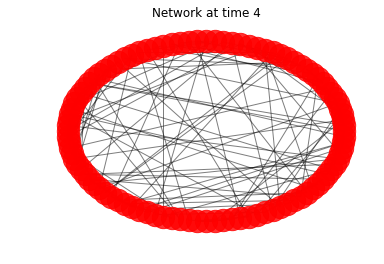

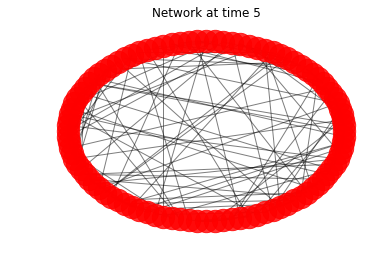

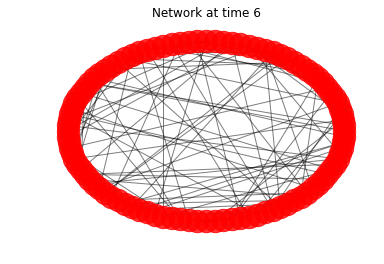

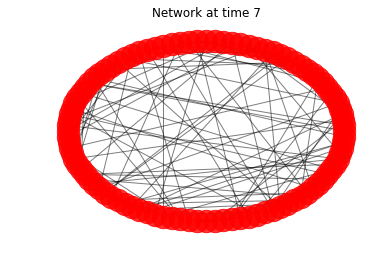

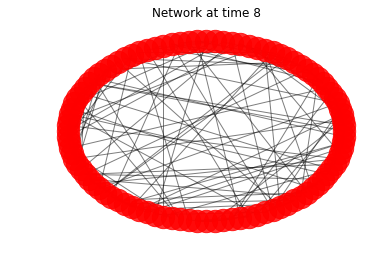

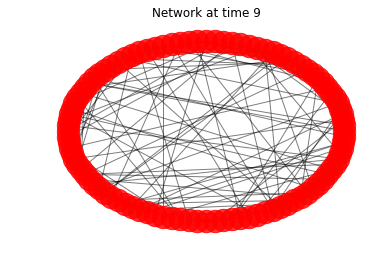

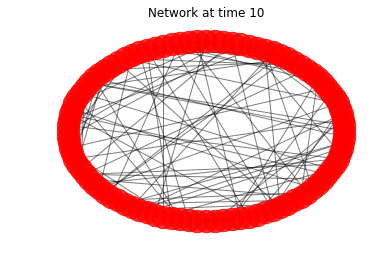

In [40]:
thetas, thetas_obs, ells = generate_dataset_L1(n_dim_obs=100, proportional=False)
for i, theta in enumerate(thetas):
    plot_graph_with_latent_variables(theta, 100, 0, "Network at time "+str(i+1))